In [1]:
import os
import sys
import numpy as np
from pathlib import Path

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent.parent.parent))

# Import custom modules
from src import Tensor, loss_functions, optimizers, metrics
from src.architectures.transformer import Tokenizer, DecoderTransformer
from src.core.utils import data_analysis, data_processing, context_manager
from src.architectures.transformer.config import TransformerConfig, DeepSeekTransformerBlockConfig, LatentAttentionConfig, MOEConfig, MLPConfig

### Constants and hyperparameters

In [2]:
# Constants
dataset_path = os.path.join(os.getcwd(), 'dataset', 'shakespeare.txt')
tokenizer_path = os.path.join(os.getcwd(), 'checkpoints', 'tokenizer_shakespeare.json')
model_path = os.path.join(os.getcwd(), 'checkpoints', 'language_model_shakespeare')

In [3]:
# Hyperparameters
dropout = 0.1 # The dropout rate
maximum_samples = 19840 # The maximum number of samples to use from the dataset
train_test_split_pct = 0.1 # 90% of the data will be used for training, 10% for testing
train_valid_split_pct = 0.1 # 90% of the training data will be used for training, 10% for validation
batch_size = 8 # The number of samples to use for each batch
grad_accumulation_steps = 4 # The number of steps to accumulate gradients before updating the model
max_sequence_length = 256 # The size of the sequence length (the context window)
learning_rate = 5e-4 # The learning rate for the optimizer
weight_decay = 0.01 # The weight decay for the optimizer
epochs = 1 # The number of epochs to train the model for
n_embed = 384 # The size of the token embeddings (the dimensionality of the embeddings)
n_attention_heads = 6 # The number of attention heads in the multi-head attention mechanism
n_decoder_blocks = 6 # The number of transformer decoder blocks in the model

### Data loading

In [4]:
def load_txt_file(path: str) -> str:
    """
    Load a text file from the specified path.
    
    Parameters:
    - path (str): The path to the text file.
    
    Returns:
    - str: The contents of the text file.
    """
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f'The file "{path}" does not exist.')
    
    # Read the file
    with open(path, 'r', encoding='utf-8') as file:
        return file.read()

In [5]:
# Instantiate the tokenizer
tokenizer = Tokenizer()

# Load the state of the tokenizer
tokenizer.load(tokenizer_path)

# Extract the vocabulary size
vocab_size = tokenizer.get_vocab_size()

In [6]:
# Load the text file
text = load_txt_file(dataset_path)

# Encode the text using the tokenizer
encoded_text = tokenizer.encode(text)

# Convert the data to a tensor
data = np.array(encoded_text)

### Data preprocessing

In [7]:
def build_sequences(input_data: np.ndarray, seq_length: int, num_samples: int) -> tuple[Tensor, Tensor]:
    """
    Build sequences
    
    Parameters:
    - input_data: np.ndarray, input features
    - seq_length: int, length of input sequences
    - num_samples: int, number of sequences to generate
    
    Returns:
    - tuple[Tensor, Tensor], input sequences and targets
    """
    
    # Initialize lists to hold sequences and targets
    X, y = [], []
    n = len(input_data)
    
    # Iterate over the number of samples to create
    for _ in range(num_samples):
        # Generate a random starting index for the sequence
        start_idx = np.random.randint(0, n - seq_length - 1)
        
        # Extract the input and target sequences
        # The input sequence is the current sequence of length seq_length
        # The target sequence is the next sequence of length seq_length (shifted by one)
        input_sequence = input_data[start_idx : start_idx + seq_length]
        target_sequence = input_data[start_idx + 1 : start_idx + seq_length + 1]
        
        # Aggiungi le sequenze alle liste
        X.append(input_sequence)
        y.append(target_sequence)
    
    # Convert the lists to numpy arrays and return as Tensors
    return Tensor(np.array(X, dtype=np.int32)), Tensor(np.array(y, dtype=np.int32))

In [8]:
# Build sequences from the encoded text data
X, y = build_sequences(data, max_sequence_length, maximum_samples)

# Shuffle the data
X_shuffled, y_shuffled = data_processing.shuffle_data((X, y))[0]

### Data splitting

In [9]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((X_shuffled, y_shuffled), train_test_split_pct, shuffle=True)[0]
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split_pct, shuffle=True)[0]

# Print the dataset information
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (16071, 256) (16071, 256)
Validation set: (1785, 256) (1785, 256)
Testing set: (1984, 256) (1984, 256)


### Building the model

In [10]:
# Create the language model
language_model = DecoderTransformer(
    name = "Language Model",
    config = TransformerConfig(
        input_dim = vocab_size, # The size of the input vocabulary
        embed_dim = n_embed, # The size of the token embeddings
        num_blocks = n_decoder_blocks, # The number of transformer blocks
        max_sequence_length = max_sequence_length, # The length of the input sequences
        return_sequence = True, # Return the full sequence output
        input_type = "discrete", # Discrete input type for token IDs
        positional_encoding_type = "learned", # Positional encoding type
        block_config = DeepSeekTransformerBlockConfig(
            attention_config = LatentAttentionConfig(
                num_heads = 4, # Number of attention heads
                dropout = 0.1, # Dropout rate
                causal = True, # Causal attention
                q_lora_rank = 64, # LoRA rank for query
                qk_lora_rank = 64, # LoRA rank for query-key
                qk_nope_head_dim = 16, # NoPE head dimension for query-key
                qk_rope_head_dim = 16, # RoPE head dimension for query-key
                kv_lora_rank = 32, # LoRA rank for key-value
                v_head_dim = 32, # Head dimension for value
                softmax_scale = 1.0 # Softmax scaling factor
            ),
            ffn_config = MOEConfig(
                top_k = 2, # Top-k experts to use
                n_groups = 1, # Number of expert groups
                top_k_groups = 1, # Number of top-k groups
                score_function = "softmax", # Scoring function for routing
                route_scale = 1.0, # Scaling factor for routing scores
                n_routed_experts = 4, # Number of routed experts
                n_shared_experts = 2, # Number of shared experts
                mlp_config = MLPConfig(
                    dropout = 0.1, # Dropout rate
                    hidden_dim = 256 # Hidden dimension
                )
            )
        )
    )
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy(from_sequence=True)

### Initializing the model

In [ ]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Call the model with a batch of data to initialize it
    language_model(x=X_train[:batch_size])

In [12]:
# Display the model summary in tree format.
# This is useful since the whole model is composed of submodules,
# therefore, the model summary will be displayed recursively
language_model.summary(recursive=True)

Language Model (DecoderTransformer) [output_shape=(8, 256, 1024), params=12186712]
└── language_model.modules (ModuleList) [output_shape=(8, 256, 1024), params=12186712]
    └── module_list.0 (Decoder) [output_shape=(8, 256, 1024), params=12186712]
        ├── decoder.input_proj (Embedding) [output_shape=(8, 256, 384), params=393216]
        ├── decoder.positional_encoding (Embedding) [output_shape=(256, 384), params=98304]
        ├── decoder.decoder_blocks (ModuleList) [output_shape=?, params=11300184]
        │   ├── module_list.0 (Block) [output_shape=(8, 256, 384), params=1883364]
        │   │   ├── block.mla (SelfMultiHeadLatentAttention) [output_shape=(8, 256, 384), params=106592]
        │   │   │   ├── self_multi_head_latent_attention.wq_a (Dense) [output_shape=(8, 256, 64), params=24576]
        │   │   │   ├── self_multi_head_latent_attention.q_norm (RMSNorm) [output_shape=(8, 256, 64), params=64]
        │   │   │   ├── self_multi_head_latent_attention.wq_b (Dense) [output

### Training the model

In [ ]:
# Train the model
history = language_model.fit(
    train_data = {'x': X_train},
    valid_data = {'x': X_valid},
    y_train = y_train,
    y_valid = y_valid,
    optimizer = optimizer,
    loss_fn = loss_fn,
    batch_size = batch_size,
    epochs = epochs,
    gradient_accumulation_steps = grad_accumulation_steps
)

Epoch 1/1 (10.25%) | 1480 tensors in memory | 1170.81 ms/step --> loss: 3.9539

KeyboardInterrupt: 

In [14]:
# Save the model 
language_model.save(model_path)

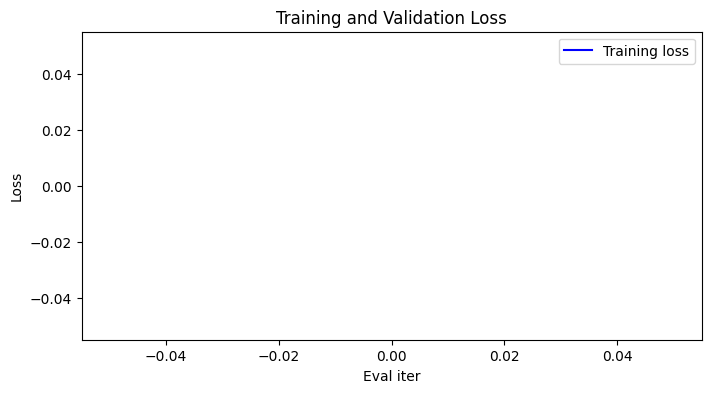

In [15]:
# Plot the training and validation loss
data_analysis.plot_history(
    train_loss = language_model.history["loss"], 
    valid_loss = language_model.history["val_loss"], 
    title = "Training and Validation Loss", 
    xlabel = "Eval iter",
    ylabel = "Loss"
)

### Evaluation

In [16]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    language_model.eval()
    
    # Compute the predictions
    predictions = language_model(X_test[:256], batch_size=batch_size, verbose=True)

# Apply the argmax function to the predictions
predictions = Tensor(np.argmax(predictions.data, axis=-1), dtype=np.int8)

Processing batch 32/32 - 539.77 ms/step

In [17]:
# Compute the accuracy
accuracy = metrics.accuracy(y_test[:256, -1], predictions[:, -1])

# Print the accuracy
print(f"Accuracy: {accuracy.data:.2f}")

Accuracy: 0.19


### Inference

In [18]:
# Generate some text context from the trained model
context = Tensor(np.zeros((1, 1), dtype=np.int32))

# Iterate over the tokens generated by the transformer
for token in language_model.autoregressive_generation(x=context, num_steps=200, stream=True, do_sample=True):
    # Decode the token - use .item() to extract the scalar value
    decoded_token = tokenizer.decode([int(token.data.item())])

    # Print the decoded token
    print(decoded_token, end='', flush=True)

 such conuch con hnover hnoverlflfENKINGENKING.
.
AA:
:
NNemempp  WoWo b beaiseais my my to tot t stst hav have fe fgood tgood t theon theonce hce hciciouldould. . ielielverver'd 'd notirnotir,
T,
Tinging
U
URLORLOan man myselfenyselfen.
;.
;s,
s,
SSealterealterleletyty; ; y,y, n nowerower oun ounOlaOla.

C.

CAAongenongen is is to toyy his his k k'd con'd conerrerrOF pOF pursesurses w we thee theendend you  you ecaecaipilipilToToopopON:
ON:
Th.

Th.

WWorioriideideFor sirst For sirst andand p pustessustess in the in the c cliyliy,!
,!
A wA wbe be  our ourbidbid  vcvce heae heavenvenessessA gA gentlementlematat' hea' heaven;
ven;
MPMP==ouldould, , is sis sINAINA way way  liellielerers ss sodeode wow wow haand haand t tratrat him,
 him,
iv tiv too her her